In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# Load data
df_w = load_data(file_name="df_weekly_896.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name="dict_weekly_896.pkl", file_path=WORK_DATA_DIR)

# correlation

In [5]:
# select model features
cols = [
    'vixo',
     # 'naaim_ind',
     'ff_M_RF',
     'ff_SMB',
     'ff_RMW',
     'ff_CMA',
    'ff_HML',
     'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
    'sp_close',
    'sp_close_lag1',
    'sp_close_lag2',
    'sp_close_lag3',
    'sp_agg1',
    # 'goog_sent',
    # 'fears35'
]

In [6]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

In [7]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["sp_cols"]],
              "sp_close_lead1",
              show_plot=False)

[['vixo', 7, 0.084],
 ['ff_M_RF', 0, 0.076],
 ['ff_SMB', 4, 0.054],
 ['ff_RMW', 0, 0.082],
 ['ff_CMA', 1, 0.053],
 ['ff_HML', 5, 0.106],
 ['termspread', 4, 0.072],
 ['aaii_Bullish', 6, 0.083]]

In [11]:
df_ws = shift_var_relative_to_df(df_ws, shift_var=["ff_CMA", 
                                                   "vixo",
                                                   # "naaim_ind",
                                                   "ff_HML"
                                                   # "naaim_ind",
                                                   # "aaii_Bullish"
                                                  ], no_lags=[
    1,
    7,
    # 8,
    5
    # 8,
    # 6
])

# Multicolinerarity

,VIF,corr_sp_close_lead1
sp_close,1.640643,-0.088164
vixo,1.021253,-0.084351
ff_M_RF,1.665156,-0.076993
sp_close_lag2,2.114692,-0.052241
ff_CMA,1.027688,-0.050763
termspread,1.079282,-0.027010
sp_agg1,3.586978,-0.026624
sp_close_lag3,1.878865,0.010110
sp_close_lag1,2.113471,0.017934
ff_SMB,1.140822,0.037514


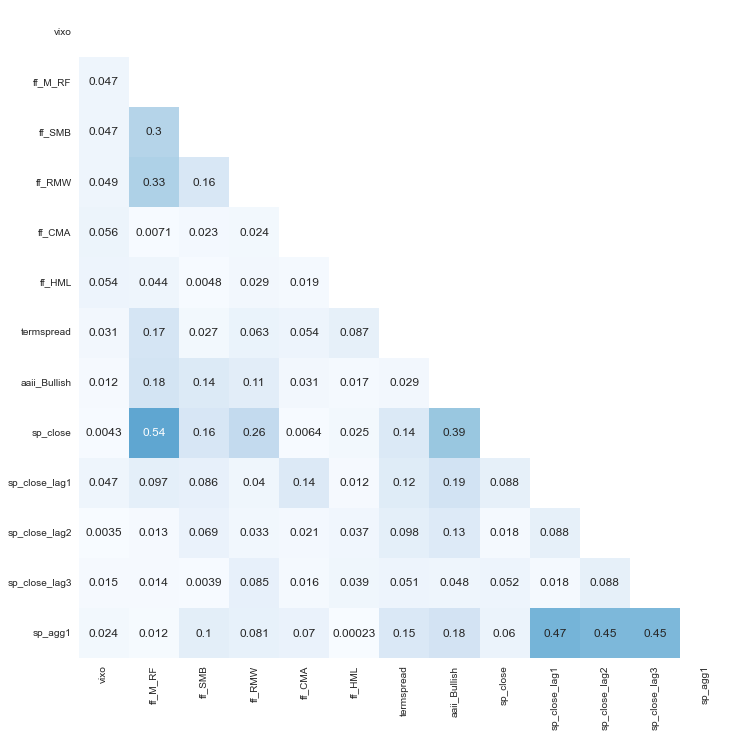

In [12]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             size_factor=.8,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# Regression

In [13]:
df_train = df_ws.copy()

In [14]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False, test_size=.2)

In [15]:
model = sm.OLS(y_train, X_train).fit()

In [16]:
model.pvalues < 0.05

vixo              True
ff_M_RF           True
ff_SMB           False
ff_RMW           False
ff_CMA            True
ff_HML            True
termspread       False
aaii_Bullish      True
sp_close          True
sp_close_lag1    False
sp_close_lag2    False
sp_close_lag3    False
sp_agg1          False
intercept        False
dtype: bool

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     5.335
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           3.32e-09
Time:                        15:22:19   Log-Likelihood:                 1655.0
No. Observations:                 711   AIC:                            -3282.
Df Residuals:                     697   BIC:                            -3218.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo             -0.0179      0.007     -2.645      0.008      -0.031      -0.005
ff_M_RF          -0.0029      0.001     -3.082      0.002      -0.005      -0.001
ff_SMB           -0.0010      0.002     -0.562      0.574      -0.004       0.002
ff_RMW           -0.0004      0.003     -0.155      0.877      -0.006       0.005
ff_CMA           -0.0077      0.003     -2.433      0.015      -0.014      -0.001
ff_HML            0.0038      0.001      2.965      0.003       0.001       0.006
termspread        0.0005      0.007      0.080      0.937      -0.013       0.014
aaii_Bullish      0.0213      0.005      4.051      0.000       0.011       0.032
sp_close         -0.1308      0.046     -2.838      0.005      -0.221      -0.040
sp_close_lag1    -0.0156      0.054     -0.290      0.772      -0.121       0.090
sp_close_lag2    -0.0032      0.053     -0.060      0.952      -0.106       0.100
sp_close_lag3     0.0074      0.048      0.154      0.878      -0.088       0.102
sp_agg1           0.0321      0.037      0.869      0.385      -0.040       0.105
intercept         0.0013      0.001      1.350      0.177      -0.001       0.003
==============================================================================
Omnibus:                      134.558   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              950.043
Skew:                          -0.641   Prob(JB):                    5.02e-207
Kurtosis:                       8.516   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

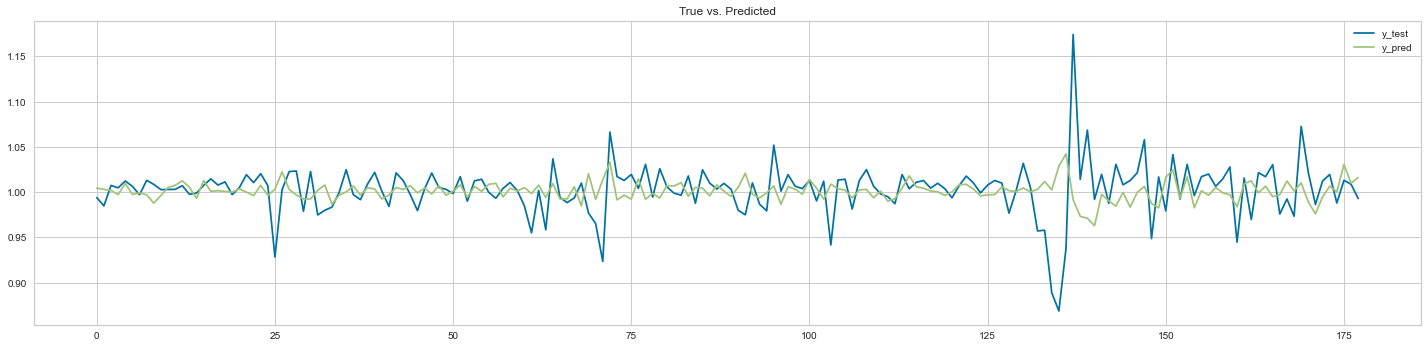

Validation Scores
mean squared error: 0.00101307
mean absolute error: 0.02016869
R2: -0.2162


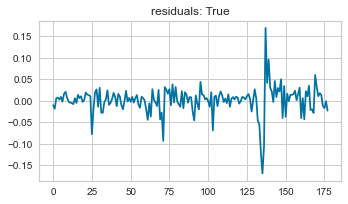

Stationarity Test Results
P-Values: 8.164748065296835e-11
Test-stats: -7.3874751837821355
Time series is stationary: True


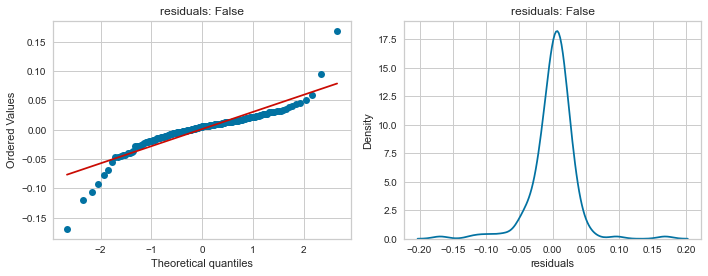

Normality Test Results
P-Values: 9.211446398505528e-13
Test-stats: 55.426318648919555
Series is normally distributed: False


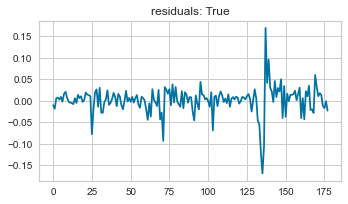

Test for Heteroskedasticity
Test p-value: 3.997060868352966e-05
Heteroskedasticity is present: True


In [18]:
# ar1 model als baseline
# add variables progressively, to obtain best
# random walk with drift, as benchmark model
# take root mean squared error as metrics
mval = ModelValidation(
    X_train,
    y_train,
    X_test,
                y_test,
                model,
                data_dict)
mval.get_model_performance()
mval.analyse_resids(print_results=True)

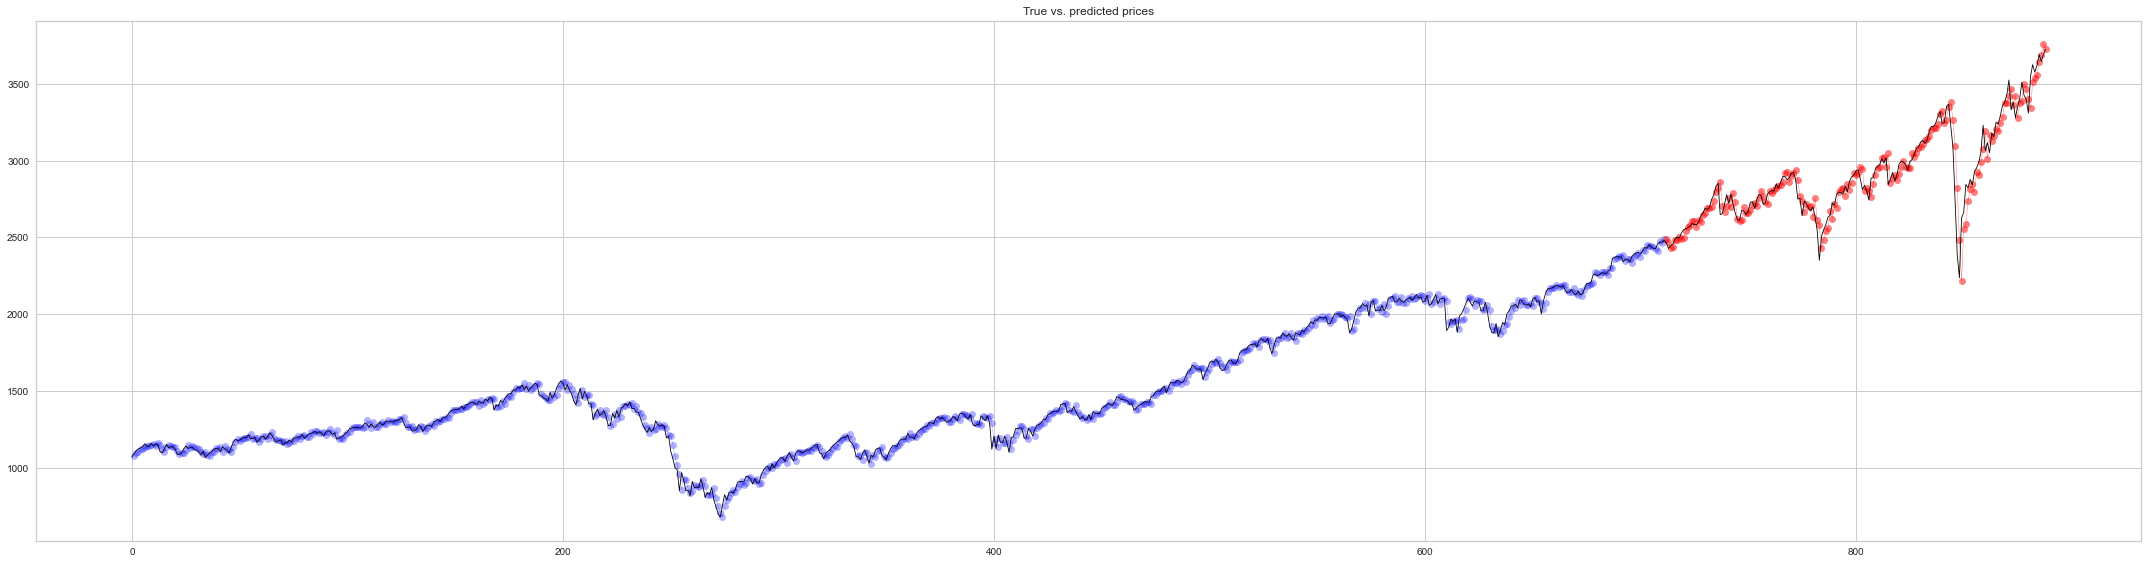

Validation Scores Test Data
mean squared error: 7770.964150055004
mean absolute error: 57.85757445066899
mean absolute error %: 3.271522782136204


In [19]:
mval.plot_results_on_price_scale(df_w,
                                 df_ws)

# Save model

In [17]:
save_model(df_train, model, mval, data_dict, name="four_features_vixo_splag_splagmul_pcr_ffMRF", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-10_four_features_vixo_splag_splagmul_pcr_ffMRF_model.pkl"? (y/n)


 n
